# Causal Analysis Workflow & Estimating ATE Using `skmiscpy`

Here we will show how we can do a very basic causal analysis using the python package `skmiscpy`. The following example content and the data used in this example are taken from (Heiss, 2024). It is highly recommended to read the post,

> Heiss, Andrew. 2024. "Demystifying Causal Inference Estimands: ATE, ATT, and ATU." March 21, 2024. https://doi.org/10.59350/c9z3a-rcq16.

## Does anti-mosquito bed nets reduce the risk of malaria?

Here we will use the `mosquito_nets_v2.csv`  data. The data is observational and non-experimental since people choose to use the nets or not based on personal preferences. In this case, income and health confound the net → malaria risk relationship: income influences health, and both income and health influence the choice to use a net and overall malaria risk.

We have four main variables in this data:

- Net use (Treatment): Binary 0/1, TRUE/FALSE variable indicating if the person uses a bed net.

- Malaria risk (Outcome): Scale from 0–100, with higher values representing greater risk.

- Income (Confounder): Weekly income, measured in dollars. Higher income causes a higher probability of using a net; people above the 80th percentile get an extra boost in probability.

- Health (Confounder): Health status, scale from 0–100, with higher values representing better health. Better health causes a higher probability of using a net; people above the 80th percentile get an extra boost in probability.

### Setup

In [1]:
import pandas as pd
import statsmodels.formula.api as smf

from skmiscpy import here
from skmiscpy import compute_smd, plot_smd
from skmiscpy import plot_mirror_histogram

In [2]:
nets = pd.read_csv(here("example_data/mosquito_nets_v2.csv"))

nets.head()

,id,income,health,net,malaria_risk
0,1,379,56,0,50.1
1,2,528,39,0,59.4
2,3,608,54,1,34.9
3,4,265,21,0,82.8
4,5,543,51,0,42.5


Since the data used here is non-experimental, we will calculate ATE using IP weighting. For that at first we need to predict the propensity score (i.e. probability of using the bed nets, which is the treatment in this example) and weight the data using this propensity score.

### Propensity Score Estimation

In [3]:
ps_model = smf.logit(
    "net ~ income + health",
    data = nets
).fit(disp = 0)

data_ps = nets.assign(ps = ps_model.predict(nets))

data_ps[['net', 'malaria_risk', 'ps']].head()

,net,malaria_risk,ps
0,0,50.1,0.393401
1,0,59.4,0.427308
2,1,34.9,0.759827
3,0,82.8,0.036798
4,0,42.5,0.622325


We can draw a mirror histogram to assess the propensity scores. To draw the mirror histogram we will use a function `plot_mirror_histogram()` from the `skmiscpy` package.

### Visualizing the propensity score 

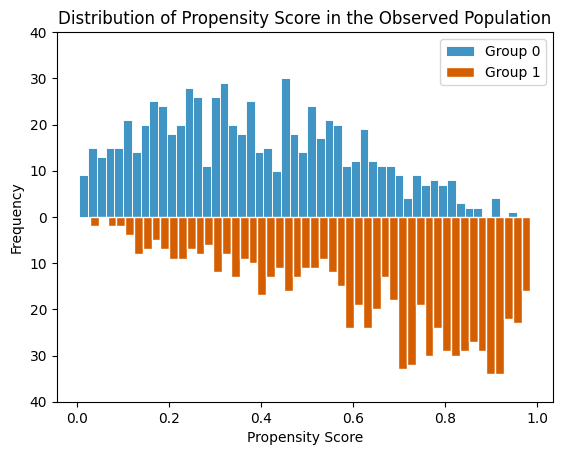

In [4]:
plot_mirror_histogram(
    data = data_ps,
    var = 'ps',
    group = 'net',
    title = "Distribution of Propensity Score in the Observed Population",
    xlabel = "Propensity Score"
)

The above graph shows a clear imbalance between the treated group (Group 1:, who chose to use the mosquito net) and the untreated group (Group 0: who didn't use the mosquito net). Such imbalance in the probability of getting treatment between the treated and untreated group does make sense. Because treatment assignment (which is mosquito nets in this case) was not randomized and assignment is biased by the users' personal perference towards the mosquito nets. And we are assuming that users' perference is affected by their health and income. 

Now let's calculate the inverse probability weights (IPW) using which we will create a weighted pseudo population. The formula of IPW for the causal estimand ATE is,

$$
w_{ATE} = \dfrac{T_i}{p_i} + \dfrac{1- T_i}{1 - p_i} \; ,
$$

where $p_i = P(T_i = 1 \vert X)$ is the predicted probability of receiving treatment from a treatment ~ confounder regression model (aka, propensity scores) for each person or unit.

In [5]:
data_wt = (
    data_ps
      .assign(
        wts_ate = data_ps['net'] / data_ps['ps'] + (1 - data_ps['net']) / (1 - data_ps['ps'])
      )
)

data_wt.head()


,id,income,health,net,malaria_risk,ps,wts_ate
0,1,379,56,0,50.1,0.393401,1.648534
1,2,528,39,0,59.4,0.427308,1.746139
2,3,608,54,1,34.9,0.759827,1.316089
3,4,265,21,0,82.8,0.036798,1.038204
4,5,543,51,0,42.5,0.622325,2.647782


The `plot_mirror_histogram` function has an optional argument `weights`. We will refer the `wts_ate` column to this argument so that we can see the weighted distribution of propensity score.

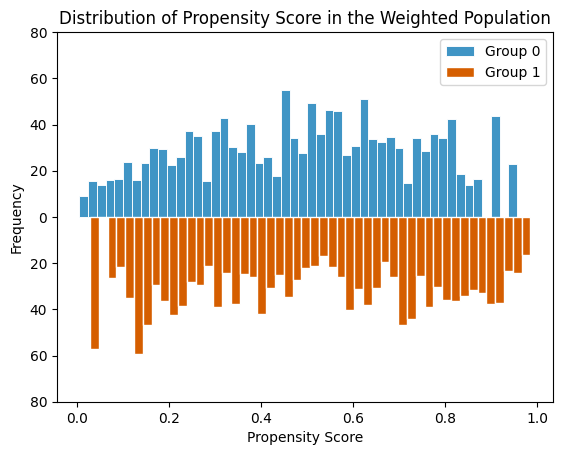

In [6]:
plot_mirror_histogram(
    data = data_wt,
    var = 'ps',
    group = 'net',
    weights = 'wts_ate',
    title = "Distribution of Propensity Score in the Weighted Population",
    xlabel = "Propensity Score"
)

These weighted treated and untreated groups look like free of the confounding coming from health and income and are arguably more comparable, acting more like randomized treated and untreated groups.

#### Checking Covariate Balance

Now we will check and compare the standardized mean difference (SMD) for the confounders `health` & `income` in the both unweighted and weighted (i.e. adjusted by `wts_ate` weight) data. We will use `compute_smd` function from `skmiscpy` to do this.

In [7]:
smd_df = compute_smd(
    data = data_wt,
    vars = ['health', 'income'],
    group = 'net',
    wt_var = 'wts_ate',
    estimand = 'ATE'
)

smd_df

,variables,unadjusted_smd,adjusted_smd
0,health,1.103463,0.014869
1,income,1.061222,0.041609


The adjusted (i.e. weighted) SMDs for both counfounders are less than the which denotes really good covariate balance. We can see the balance using love plot. The `plot_smd` function from `skmiscpy` package helps us to draw a love plot.

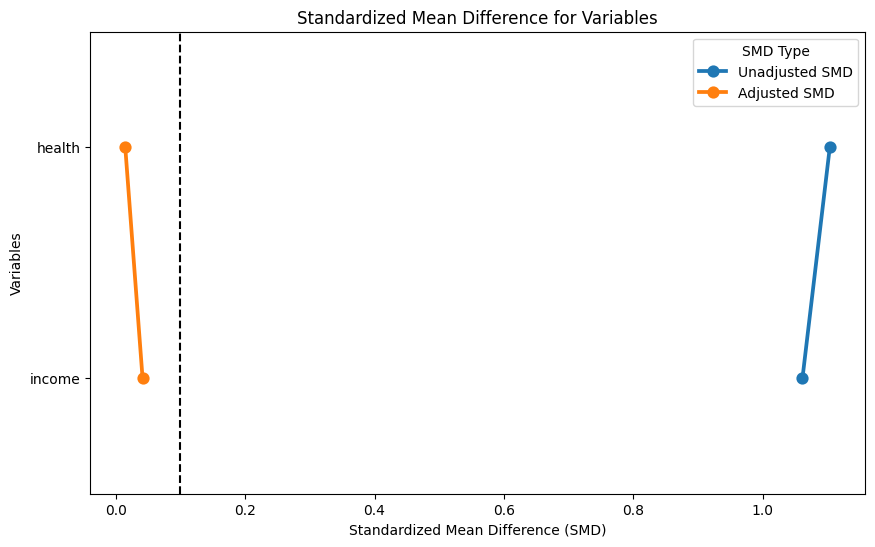

In [9]:
plot_smd(smd_df, add_ref_line = True, ref_line_value = 0.1)

### Estimating the ATE

Now we can esitimate the ATE which describes the causal effect of mosquito nets on reducing the malaria risk.

In [10]:
outcome_model = (
    smf.wls(
        formula = 'malaria_risk ~ net', 
        weights = data_wt['wts_ate'], 
        data = data_wt
    )
    .fit()   
)

# Predict outcomes when net = 1
nets_1 = nets.copy()
nets_1['net'] = 1
pred_1 = outcome_model.predict(nets_1)

# Predict outcomes when net = 0
nets_0 = nets.copy()
nets_0['net'] = 0
pred_0 = outcome_model.predict(nets_0)

mean_difference = (pred_1 - pred_0).mean()
print(mean_difference)


-14.661421260549304


So we can say, using a mosquito net reduces the risk of malaria by 14.7 points, on average across all people in the country.

**On a different note**, we are using a function `here` (inspired by R function [`here::here()`](https://here.r-lib.org/reference/here.html)) in the `pd.read_csv()`, which helps us to write path relative to the project root directory. And we believe each python project should contain a separate virtual environment directory (like the one `python -m venv venv` creates), hence we have build the `here()` function to consider the directory with virtual env folder as the root directory. Here is the directory structure of this project,

~~~ bash
├── README.md
├── docs
│   ├── example.ipynb
├── example_data
│   └── mosquito_nets_v2.csv
├── src
│   └── python_file.py
└── venv
~~~

And `here()` allows to refer to `mosquito_nets_v2.csv` data by writing `"example_data/mosquito_nets_v2.csv"`, instead of writing `"../example_data/mosquito_nets_v2.csv"`. 